### Library 불러오기

In [1]:
from influxdb import InfluxDBClient
from influxdb import DataFrameClient
import pandas as pd
import numpy as np
from datetime import timedelta
from pandas.tseries.offsets import MonthEnd

# 한국의 공휴일
from workalendar.asia import SouthKorea

# 시각화
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc


font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

> **Reference**  
> - [InfluxDB-Python](https://influxdb-python.readthedocs.io/en/latest/examples.html)
> - [Explore data using InfluxQL](https://docs.influxdata.com/influxdb/v1.8/query_language/explore-data/)

### ETRI server 접속 정보 및 client 연결

In [2]:
dong_li = ['102_208','102_506','102_1501']

In [139]:

# InfluxDB 접속정보
host = '182.252.135.208'
port = 8086
user = 'root'
password = 'root'
dbname = 'carpediem'

# DataFrameClient : pd.DataFrame을 출력하기 위한 연결 메서드
client = DataFrameClient(host, port, user, password, dbname)

# 동, 호수, CCM 설정(가전기기 powermeter) 및 기간 
# dong = dongho[:3]   # '101_402' 중 '101'
# ho = dongho[4:]     # '101_402' 중 '402'

dong = '102'   # '101_402' 중 '101'
ho = '1501'     # '101_402' 중 '402'


sensor_type = 'CCM'
start_time = '2022-08-01'
end_time = '2022-08-31'


def import_data(start_time, end_time,sensor_type):
    '''
    start_time : 시작일
    end_time : 종료일
    '''
    month_start_day_list = [str(i) for i in pd.date_range(start_time, end_time, freq = "MS")]
    month_endtime = str(pd.to_datetime(start_time) + MonthEnd())[:10] + ' 23:59:59'
    print(start_time, "~", month_endtime, "loading...")
    
    # Data of the first month
    query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+start_time+"' and time<='"+month_endtime+"' tz('Asia/Seoul')"
    data = client.query(query)
    df = data['shindo']
    
    print(start_time, "~", month_endtime, "finished")

    # Data of the second month and more
    for temp_starttime in month_start_day_list[1:]:
        temp_endtime = str(pd.to_datetime(temp_starttime) + MonthEnd())[:10] + ' 23:59:59'
        temp_query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+temp_starttime+"' and time<='"+temp_endtime+"' tz('Asia/Seoul')" 
        print(temp_starttime, "~", temp_endtime, "loading...")
        
        # query 요청
        temp_data = client.query(temp_query)

        # pd.DataFrame으로 변환
        temp_df = temp_data['shindo']
        
        print(temp_starttime, "~", temp_endtime, "finished")
        df = pd.concat([df, temp_df])
        
    # index를 KST로 변경
    df.index = df.index + timedelta(hours=9)
    
    return df

In [140]:
df = import_data(start_time, end_time,sensor_type)

2022-08-01 ~ 2022-08-31 23:59:59 loading...
2022-08-01 ~ 2022-08-31 23:59:59 finished


### device 변수 설정

- `deviceId`:`name` 및 `room` 에 따른 unique한 id를 갖도록 파생변수 `name (room)` 생성

In [142]:
# 개별 device ID 확인 (13개)
deviceId_list = df['deviceId'].unique().tolist()
print("deviceID list : {0}".format(deviceId_list))
print("--------------------------------------------")
#개별 device의 nickname 확인
nickname_temp_list = df['nickname'].unique().tolist()
nickname_list = [i for i in nickname_temp_list if i is not None]
device_temp_id_nick_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'nickname']].values)
print("nickname list : {0}".format(device_temp_id_nick_dict))
print("--------------------------------------------")

# 개별 device의 room 확인
# room_temp_list = df['room'].unique().tolist()
# room_list = [i for i in room_temp_list if i is not None]
device_temp_id_room_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'room']].values)

print("room list : {0}".format(device_temp_id_room_dict))

deviceID list : ['CCMce060d', 'CCMce0615', 'CCMce0619', 'CCMce062a', 'CCMce0621', 'CCMce0823', 'CCMce083a', 'CCMce0839', 'CCMce0832', 'CCMce084a', 'CCMce0835', 'CCMce05e9']
--------------------------------------------
nickname list : {'CCMce060d': '선풍기', 'CCMce0615': 'TV3', 'CCMce0619': 'PC', 'CCMce062a': 'TV2', 'CCMce0621': '전기밥솥', 'CCMce0823': '에어컨', 'CCMce083a': '전자레인지', 'CCMce0839': '노트북', 'CCMce0832': '에어컨', 'CCMce084a': '선풍기1', 'CCMce0835': '세탁기', 'CCMce05e9': 'TV'}
--------------------------------------------
room list : {'CCMce060d': '방1', 'CCMce0615': '방2', 'CCMce0619': '방1', 'CCMce062a': '방1', 'CCMce0621': '주방', 'CCMce0823': '거실', 'CCMce083a': '주방', 'CCMce0839': '방3', 'CCMce0832': '방1', 'CCMce084a': '방1', 'CCMce0835': '발코니2', 'CCMce05e9': '거실'}


In [148]:
# 기존 device별 nickname 결측값(None) 채우기
for key, value in device_temp_id_nick_dict.items():
    df.loc[df['deviceId'] == key, 'nickname'] = value

# 기존 device별 room 결측값(None) 채우기    
for key, value in device_temp_id_room_dict.items():
    df.loc[df['deviceId'] == key, 'room'] = value
# 파생변수 생성 : name (room) 
df['name(room)'] = df['nickname'] + " (" + df['room'] + ")"

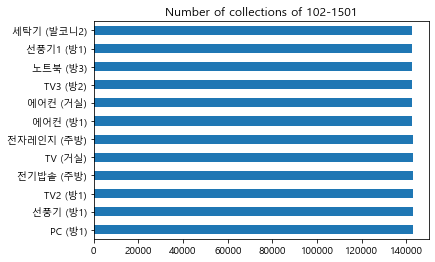

In [149]:
# 약 한달동안 수집된 raw data 갯수
df['name(room)'].value_counts().plot.barh()
plt.title("Number of collections of " + dong + "-" + 
          ho)
plt.grid(False)

### time(index) 및 device(column)에 따른 power 확인
---

> **real time data**

In [150]:
idx = df.index

In [151]:
df['date'] = idx

In [152]:
# row : time, colulmn : 각각의 device, value : power 로 구성된 df 추출
columns = ['name(room)', 'power']
df_device_power =  df[columns]
df_device_power = df_device_power.pivot(columns='name(room)', values='power')
df_device_power

name(room),PC (방1),TV (거실),TV2 (방1),TV3 (방2),노트북 (방3),선풍기 (방1),선풍기1 (방1),세탁기 (발코니2),에어컨 (거실),에어컨 (방1),전기밥솥 (주방),전자레인지 (주방)
2022-08-01 00:00:03.818493+00:00,NaN,NaN,NaN,NaN,NaN,29.5,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01 00:00:03.845863+00:00,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01 00:00:03.846531+00:00,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01 00:00:03.848983+00:00,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01 00:00:03.850246+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-19 10:24:21.016170+00:00,NaN,NaN,NaN,NaN,33.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-19 10:24:21.035391+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN,NaN
2022-08-19 10:24:21.035667+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.8
2022-08-19 10:24:21.035791+00:00,NaN,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### resolution 에 따른 dataframe 설정
---
> **resolution이 반영된 data**

In [38]:
# resampling 함수 (평균)
def resampling(df, interval):
    df = df.resample(interval).max()
    return df

# interval 설정에 따른 전처리
interval = '300S'    # 15 min 간격 설정

df_device_resolution_5min = resampling(df_device_power, interval)
df_device_resolution_5min.fillna(0).to_csv("{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))
display(df_device_resolution_5min.isna().sum())

name(room)
 (거실)      544
 (방1)      536
 (방2)      636
 (침실3)    6064
dtype: int64

# USM 불러오기

In [3]:
for i,dongho in enumerate(dong_li):
    # InfluxDB 접속정보
    host = '182.252.135.208'
    port = 8086
    user = 'root'
    password = 'root'
    dbname = 'carpediem'

    # DataFrameClient : pd.DataFrame을 출력하기 위한 연결 메서드
    client = DataFrameClient(host, port, user, password, dbname)

    # 동, 호수, CCM 설정(가전기기 powermeter) 및 기간 
    dong = dongho[:3]   # '101_402' 중 '101'
    ho = dongho[4:]     # '101_402' 중 '402'
    sensor_type = 'USM'
    start_time = '2021-07-01'
    end_time = '2022-06-30'

    print(dongho)

    def import_data(start_time, end_time,sensor_type):
        try:
            '''
            start_time : 시작일
            end_time : 종료일
            '''
            month_start_day_list = [str(i) for i in pd.date_range(start_time, end_time, freq = "MS")]
            month_endtime = str(pd.to_datetime(start_time) + MonthEnd())[:10] + ' 23:59:59'
            print(start_time, "~", month_endtime, "loading...")
            
            # Data of the first month
            query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+start_time+"' and time<='"+month_endtime+"' tz('Asia/Seoul')"
            data = client.query(query)
            
            df = data['shindo']
            
            print(start_time, "~", month_endtime, "finished")

            # Data of the second month and more
            for temp_starttime in month_start_day_list[1:]:
                temp_endtime = str(pd.to_datetime(temp_starttime) + MonthEnd())[:10] + ' 23:59:59'
                temp_query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+temp_starttime+"' and time<='"+temp_endtime+"' tz('Asia/Seoul')" 
                print(temp_starttime, "~", temp_endtime, "loading...")
                
                # query 요청
                temp_data = client.query(temp_query)
                # pd.DataFrame으로 변환
                temp_df = temp_data['shindo']
                
                print(temp_starttime, "~", temp_endtime, "finished")
                df = pd.concat([df, temp_df])
                
            # index를 KST로 변경
            df.index = df.index + timedelta(hours=9)
            error = False
        except :
            error = True
            df = error
        
        return df,error
    
    
    
     
    df,error = import_data(start_time, end_time,sensor_type)
    
    if not error:
        # 개별 device ID 확인 (13개)
        deviceId_list = df['deviceId'].unique().tolist()
        # print("deviceID list : {0}".format(deviceId_list))
        # print("--------------------------------------------")
        # 개별 device의 nickname 확인
        # nickname_temp_list = df['nickname'].unique().tolist()
        # nickname_list = [i for i in nickname_temp_list if i is not None]
        # device_temp_id_nick_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'nickname']].values)
        # print("nickname list : {0}".format(device_temp_id_nick_dict))
        # print("--------------------------------------------")

        # 개별 device의 room 확인
        # room_temp_list = df['room'].unique().tolist()
        # room_list = [i for i in room_temp_list if i is not None]
        device_temp_id_room_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'room']].values)

        # print("room list : {0}".format(device_temp_id_room_dict))
        
        
        
        
        
        
        
        
        
        # 기존 device별 nickname 결측값(None) 채우기
        # for key, value in device_temp_id_nick_dict.items():
        #     df.loc[df['deviceId'] == key, 'nickname'] = value

        # 기존 device별 room 결측값(None) 채우기    
        for key, value in device_temp_id_room_dict.items():
            df.loc[df['deviceId'] == key, 'room'] = value

        # 파생변수 생성 : name (room) 
        df['name(room)'] = " (" + df['room'] + ")"
        
        
        
        
        
        
        
        
        
        
        
        # # 약 한달동안 수집된 raw data 갯수
        # df['name(room)'].value_counts().plot.barh()
        # plt.title("Number of collections of " + dong + "-" + 
        #         ho)
        # plt.grid(False)
        
        
        
        
        
        
        
        
        
        
        # row : time, colulmn : 각각의 device, value : power 로 구성된 df 추출
        try:
            columns = ['name(room)', 'presence']
            df_device_power =  df[columns]
            df_device_power = df_device_power.pivot_table(index=df_device_power.index,columns='name(room)',values='presence')
            # df_device_power
            
            
            
            
            
            
            
            # resampling 함수 (평균)
            def resampling(df, interval):
                df = df.resample(interval).mean().round(3)
                return df

            # interval 설정에 따른 전처리
            interval = '1S'    # 15 min 간격 설정
            df_device_resolution_15min = resampling(df_device_power, interval)
            df_device_resolution_15min.to_csv("./data/USM/USM/{}_{}_{}_{}.csv".format(dong,ho,sensor_type,interval))

            interval = '5S'    # 1 min 간격 설정
            df_device_resolution_1min = resampling(df_device_power, interval)
            df_device_resolution_1min.to_csv("./data/USM/USM/{}_{}_{}_{}.csv".format(dong,ho,sensor_type,interval))
        except:
            error = True
        
    values[i] = error
    
    
    
    
    

101_102
2021-07-01 ~ 2021-07-31 23:59:59 loading...
2021-07-01 ~ 2021-07-31 23:59:59 finished
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 loading...
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 finished
2021-09-01 00:00:00 ~ 2021-09-30 23:59:59 loading...
2021-09-01 00:00:00 ~ 2021-09-30 23:59:59 finished
2021-10-01 00:00:00 ~ 2021-10-31 23:59:59 loading...
2021-10-01 00:00:00 ~ 2021-10-31 23:59:59 finished
2021-11-01 00:00:00 ~ 2021-11-30 23:59:59 loading...
2021-11-01 00:00:00 ~ 2021-11-30 23:59:59 finished
2021-12-01 00:00:00 ~ 2021-12-31 23:59:59 loading...
2021-12-01 00:00:00 ~ 2021-12-31 23:59:59 finished
2022-01-01 00:00:00 ~ 2022-01-31 23:59:59 loading...
101_1101
2021-07-01 ~ 2021-07-31 23:59:59 loading...
101_1102
2021-07-01 ~ 2021-07-31 23:59:59 loading...
2021-07-01 ~ 2021-07-31 23:59:59 finished
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 loading...
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 finished
2021-09-01 00:00:00 ~ 2021-09-30 23:59:59 loading...
2021-09-01 00:00:00 ~ 2021-0

# CCM

In [55]:
dong_li = ['102_208','102_506','102_1501']
dong_li.sort()
values = np.zeros(len(dong_li))

In [153]:
for i,dongho in enumerate(dong_li):
    # InfluxDB 접속정보
    host = '182.252.135.208'
    port = 8086
    user = 'root'
    password = 'root'
    dbname = 'carpediem'

    # DataFrameClient : pd.DataFrame을 출력하기 위한 연결 메서드
    client = DataFrameClient(host, port, user, password, dbname)

    # 동, 호수, CCM 설정(가전기기 powermeter) 및 기간 
    dong = dongho[:3]   # '101_402' 중 '101'
    ho = dongho[4:]     # '101_402' 중 '402'
    sensor_type = 'CCM'
    start_time = '2022-08-01'
    end_time = '2022-08-31'

    print(dongho)

    def import_data(start_time, end_time,sensor_type):
        try:
            '''
            start_time : 시작일
            end_time : 종료일
            '''
            month_start_day_list = [str(i) for i in pd.date_range(start_time, end_time, freq = "MS")]
            month_endtime = str(pd.to_datetime(start_time) + MonthEnd())[:10] + ' 23:59:59'
            print(start_time, "~", month_endtime, "loading...")
            
            # Data of the first month
            query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+start_time+"' and time<='"+month_endtime+"' tz('Asia/Seoul')"
            data = client.query(query)
            
            df = data['shindo']
            
            print(start_time, "~", month_endtime, "finished")

            # Data of the second month and more
            for temp_starttime in month_start_day_list[1:]:
                temp_endtime = str(pd.to_datetime(temp_starttime) + MonthEnd())[:10] + ' 23:59:59'
                temp_query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+temp_starttime+"' and time<='"+temp_endtime+"' tz('Asia/Seoul')" 
                print(temp_starttime, "~", temp_endtime, "loading...")
                
                # query 요청
                temp_data = client.query(temp_query)
                # pd.DataFrame으로 변환
                temp_df = temp_data['shindo']
                
                print(temp_starttime, "~", temp_endtime, "finished")
                df = pd.concat([df, temp_df])
                
            # index를 KST로 변경
            df.index = df.index + timedelta(hours=9)
            error = False
        except :
            error = True
            df = error
        
        return df,error
    
    
    
     
    df,error = import_data(start_time, end_time,sensor_type)
    
    if not error:
        # 개별 device ID 확인 (13개)
        deviceId_list = df['deviceId'].unique().tolist()
        # print("deviceID list : {0}".format(deviceId_list))
        # print("--------------------------------------------")
        # 개별 device의 nickname 확인
        # nickname_temp_list = df['nickname'].unique().tolist()
        # nickname_list = [i for i in nickname_temp_list if i is not None]
        device_temp_id_nick_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'nickname']].values)
        # print("nickname list : {0}".format(device_temp_id_nick_dict))
        # print("--------------------------------------------")

        # 개별 device의 room 확인
        # room_temp_list = df['room'].unique().tolist()
        # room_list = [i for i in room_temp_list if i is not None]
        device_temp_id_room_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'room']].values)

        # print("room list : {0}".format(device_temp_id_room_dict))
        
        
        
        
        
        
        
        
        
        # 기존 device별 nickname 결측값(None) 채우기
        for key, value in device_temp_id_nick_dict.items():
            df.loc[df['deviceId'] == key, 'nickname'] = value

        # 기존 device별 room 결측값(None) 채우기    
        for key, value in device_temp_id_room_dict.items():
            df.loc[df['deviceId'] == key, 'room'] = value

        # 파생변수 생성 : name (room) 
        df['name(room)'] = df['nickname'] + " (" + df['room'] + ")"
        
        
        
        
        
        
        
        
        
        
        
        # # 약 한달동안 수집된 raw data 갯수
        # df['name(room)'].value_counts().plot.barh()
        # plt.title("Number of collections of " + dong + "-" + 
        #         ho)
        # plt.grid(False)
        
        
        
        
        
        
        
        
        
        
        # row : time, colulmn : 각각의 device, value : power 로 구성된 df 추출
        try:
            columns = ['name(room)', 'power']
            df_device_power =  df[columns]
            df_device_power = df_device_power.pivot_table(index=df_device_power.index,columns='name(room)',values='power')
            # df_device_power
            
            
            
            
            
            
            
            # resampling 함수 (평균)
            def resampling(df, interval):
                df = df.resample(interval).mean().round(3)
                return df

            # interval 설정에 따른 전처리
            # interval = '1S'    # 15 min 간격 설정
            # df_device_resolution_15min = resampling(df_device_power, interval)
            # df_device_resolution_15min.to_csv("./data/CCM/{}_{}_{}_{}.csv".format(dong,ho,sensor_type,interval))

            
            interval = '60S'    # 1 min 간격 설정
            df_device_resolution_1min = resampling(df_device_power, interval)
            df_device_resolution_1min.to_csv("./data/CCM/{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))
            df_sum_1min = df_device_resolution_1min.groupby(df_device_resolution_1min.index.date).cumsum()
            df_sum_1min.to_csv("./data/CCM/sum_{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))
            
            
            interval = '300S'    # 5 min 간격 설정
            df_device_resolution_5min = resampling(df_device_power, interval)
            df_device_resolution_5min.to_csv("./data/CCM/{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))
            df_sum_5min = df_device_resolution_5min.groupby(df_device_resolution_5min.index.date).cumsum()
            df_sum_5min.to_csv("./data/CCM/sum_{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))
        except:
            error = True
        
    values[i] = error
    
    
    
    
    

102_1501
2022-08-01 ~ 2022-08-31 23:59:59 loading...
2022-08-01 ~ 2022-08-31 23:59:59 finished
102_208
2022-08-01 ~ 2022-08-31 23:59:59 loading...
2022-08-01 ~ 2022-08-31 23:59:59 finished
102_506
2022-08-01 ~ 2022-08-31 23:59:59 loading...
2022-08-01 ~ 2022-08-31 23:59:59 finished


In [154]:
for i,dongho in enumerate(dong_li):
    
    dong = dongho[:3]   # '101_402' 중 '101'
    ho = dongho[4:]     # '101_402' 중 '402

    sensor_type = 'CCM'
    ccm = pd.read_csv("./data/CCM/{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval), index_col='Unnamed: 0', infer_datetime_format=True)
    sensor_type = 'USM'
    usm = pd.read_csv("./{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval), index_col='Unnamed: 0', infer_datetime_format=True)
    usm_onoff = 1.0*((usm ==4) | (usm==2))

    new_cols = 'presence_USM'+usm.columns
    ccm[new_cols] = usm_onoff

    sensor_type = 'CCM'
    ccm.to_csv("./data/CCM/{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))

In [158]:

# InfluxDB 접속정보
host = '182.252.135.208'
port = 8086
user = 'root'
password = 'root'
dbname = 'carpediem'

# DataFrameClient : pd.DataFrame을 출력하기 위한 연결 메서드
client = DataFrameClient(host, port, user, password, dbname)

# 동, 호수, CCM 설정(가전기기 powermeter) 및 기간 
dong = '102'   # '101_402' 중 '101'
ho = '1501'     # '101_402' 중 '402'
sensor_type = 'CCM'
start_time = '2022-08-01'
end_time = '2022-08-31'

print(dongho)

def import_data(start_time, end_time,sensor_type):
    try:
        '''
        start_time : 시작일
        end_time : 종료일
        '''
        month_start_day_list = [str(i) for i in pd.date_range(start_time, end_time, freq = "MS")]
        month_endtime = str(pd.to_datetime(start_time) + MonthEnd())[:10] + ' 23:59:59'
        print(start_time, "~", month_endtime, "loading...")
        
        # Data of the first month
        query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+start_time+"' and time<='"+month_endtime+"' tz('Asia/Seoul')"
        data = client.query(query)
        
        df = data['shindo']
        
        print(start_time, "~", month_endtime, "finished")

        # Data of the second month and more
        for temp_starttime in month_start_day_list[1:]:
            temp_endtime = str(pd.to_datetime(temp_starttime) + MonthEnd())[:10] + ' 23:59:59'
            temp_query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+temp_starttime+"' and time<='"+temp_endtime+"' tz('Asia/Seoul')" 
            print(temp_starttime, "~", temp_endtime, "loading...")
            
            # query 요청
            temp_data = client.query(temp_query)
            # pd.DataFrame으로 변환
            temp_df = temp_data['shindo']
            
            print(temp_starttime, "~", temp_endtime, "finished")
            df = pd.concat([df, temp_df])
            
        # index를 KST로 변경
        df.index = df.index + timedelta(hours=9)
        error = False
    except :
        error = True
        df = error
    
    return df,error



    
df,error = import_data(start_time, end_time,sensor_type)

if not error:
    # 개별 device ID 확인 (13개)
    deviceId_list = df['deviceId'].unique().tolist()
    # print("deviceID list : {0}".format(deviceId_list))
    # print("--------------------------------------------")
    # 개별 device의 nickname 확인
    # nickname_temp_list = df['nickname'].unique().tolist()
    # nickname_list = [i for i in nickname_temp_list if i is not None]
    device_temp_id_nick_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'nickname']].values)
    # print("nickname list : {0}".format(device_temp_id_nick_dict))
    # print("--------------------------------------------")

    # 개별 device의 room 확인
    # room_temp_list = df['room'].unique().tolist()
    # room_list = [i for i in room_temp_list if i is not None]
    device_temp_id_room_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'room']].values)

    # print("room list : {0}".format(device_temp_id_room_dict))
    
    
    
    
    
    
    
    
    
    # 기존 device별 nickname 결측값(None) 채우기
    for key, value in device_temp_id_nick_dict.items():
        df.loc[df['deviceId'] == key, 'nickname'] = value

    # 기존 device별 room 결측값(None) 채우기    
    for key, value in device_temp_id_room_dict.items():
        df.loc[df['deviceId'] == key, 'room'] = value

    # 파생변수 생성 : name (room) 
    df['name(room)'] = df['nickname'] + " (" + df['room'] + ")"
    
    
    
    
    
    
    
    
    
    
    
    # # 약 한달동안 수집된 raw data 갯수
    # df['name(room)'].value_counts().plot.barh()
    # plt.title("Number of collections of " + dong + "-" + 
    #         ho)
    # plt.grid(False)
    
    
    
    
    
    
    
    
    
    
    # row : time, colulmn : 각각의 device, value : power 로 구성된 df 추출
    try:
        columns = ['name(room)', 'power']
        df_device_power =  df[columns]
        df_device_power = df_device_power.pivot_table(index=df_device_power.index,columns='name(room)',values='power')
        # df_device_power
        
        
        
        
        
        
        
        # resampling 함수 (평균)
        def resampling(df, interval):
            df = df.resample(interval).mean().round(3)
            return df

        # interval 설정에 따른 전처리
        # interval = '1S'    # 15 min 간격 설정
        # df_device_resolution_15min = resampling(df_device_power, interval)
        # df_device_resolution_15min.to_csv("./data/CCM/{}_{}_{}_{}.csv".format(dong,ho,sensor_type,interval))

        
        interval = '60S'    # 1 min 간격 설정
        df_device_resolution_1min = resampling(df_device_power, interval)
        # df_device_resolution_1min.to_csv("./data/CCM/{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))
        df_sum_1min = df_device_resolution_1min.groupby(df_device_resolution_1min.index.date).cumsum()
        # df_sum_1min.to_csv("./data/CCM/sum_{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))
        
        
        interval = '300S'    # 5 min 간격 설정
        df_device_resolution_5min = resampling(df_device_power, interval)
        # df_device_resolution_5min.to_csv("./data/CCM/{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))
        df_sum_5min = df_device_resolution_5min.groupby(df_device_resolution_5min.index.date).cumsum()
        # df_sum_5min.to_csv("./data/CCM/sum_{}_{}_{}_{}_test.csv".format(dong,ho,sensor_type,interval))
    except:
        error = True
    
values[i] = error






102_506
2022-08-01 ~ 2022-08-31 23:59:59 loading...
2022-08-01 ~ 2022-08-31 23:59:59 finished


In [ ]:
df_device_resolution_5min

In [ ]:
df_device_resolution_5min

In [155]:
ccm

,TV (거실),TV (침실1),세탁기 (발코니2),에어컨 (거실),전기밥솥 (주방),커피포트 (주방),컴퓨터 (방3),컴퓨터 (침실3),presence_USM (거실),presence_USM (방2),presence_USM (침실2)
2022-08-01 00:00:00+00:00,82.240,11.650,0.393,519.703,0.350,0.293,0.317,0.770,1.0,0.0,0.0
2022-08-01 00:05:00+00:00,82.707,11.583,0.393,226.977,0.340,0.370,0.290,0.593,1.0,0.0,0.0
2022-08-01 00:10:00+00:00,82.762,11.577,0.400,810.524,0.287,0.327,0.320,0.707,1.0,0.0,0.0
2022-08-01 00:15:00+00:00,82.667,11.733,0.440,280.743,0.397,0.333,0.257,0.640,1.0,0.0,0.0
2022-08-01 00:20:00+00:00,82.710,11.753,0.403,467.413,0.353,0.333,0.255,0.713,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 23:35:00+00:00,82.777,11.690,0.360,0.143,31.143,0.323,0.303,0.607,1.0,0.0,0.0
2022-08-31 23:40:00+00:00,82.730,11.600,0.403,0.183,58.533,0.403,0.330,0.617,0.0,0.0,0.0
2022-08-31 23:45:00+00:00,82.713,11.567,0.397,0.167,57.093,0.367,0.347,0.587,1.0,0.0,0.0
2022-08-31 23:50:00+00:00,82.647,11.583,0.393,0.147,60.247,0.360,0.323,0.520,0.0,0.0,0.0


In [17]:
df_device_power.pivot_table(index=df_device_power.index,columns='name(room)',values='presence')

name(room),(거실),(방1),(방2),(침실3)
2021-07-01 00:00:11.946509+00:00,3.0,NaN,NaN,NaN
2021-07-01 00:00:15.213560+00:00,NaN,NaN,3.0,NaN
2021-07-01 00:00:47.188947+00:00,NaN,3.0,NaN,NaN
2021-07-01 00:01:10.033619+00:00,3.0,NaN,NaN,NaN
2021-07-01 00:01:13.246771+00:00,NaN,NaN,3.0,NaN
...,...,...,...,...
2022-06-30 23:58:48.694660+00:00,NaN,3.0,NaN,NaN
2022-06-30 23:59:20.417600+00:00,NaN,NaN,NaN,3.0
2022-06-30 23:59:30.845095+00:00,3.0,NaN,NaN,NaN
2022-06-30 23:59:37.037768+00:00,NaN,NaN,3.0,NaN


In [18]:
def resampling(df, interval):
    df = df.resample(interval).mean().round(3)
    return df

# interval 설정에 따른 전처리
interval = '1S'    # 15 min 간격 설정
df_device_resolution_15min = resampling(df_device_power, interval)
df_device_resolution_15min.to_csv("./data/USM/{}_{}_{}_{}.csv".format(dong,ho,sensor_type,interval))

interval = '5S'    # 1 min 간격 설정
df_device_resolution_1min = resampling(df_device_power, interval)
df_device_resolution_1min.to_csv("./data/USM/{}_{}_{}_{}.csv".format(dong,ho,sensor_type,interval))

In [2]:
dong_li = ['101_102','101_301','101_302','101_402','101_502','101_702'
           ,'101_1101','101_201','101_701','101_1102','101_1501'
           ,'101_1802','102_202','102_207','102_208','102_303'
           ,'102_402','102_502','102_506','102_609','102_702'
           ,'102_709','102_804','102_901','102_908','102_1007'
           ,'102_1101','102_1106','102_1205','102_1211','102_1301'
           ,'102_1309','102_1403','102_1405','102_1409','102_1410'
           ,'102_1501','102_1502','102_1504','102_1509','102_1703']
dong_li.sort()
values = np.zeros(len(dong_li))

In [6]:
pd.DataFrame(values,dong_li,['Error'])

,Error
101_102,0.0
101_1101,0.0
101_1102,0.0
101_1501,0.0
101_1802,0.0
101_201,0.0
101_301,0.0
101_302,0.0
101_402,0.0
101_502,0.0


In [50]:
for i,dongho in enumerate(dong_li):
    # InfluxDB 접속정보
    host = '182.252.135.208'
    port = 8086
    user = 'root'
    password = 'root'
    dbname = 'carpediem'

    # DataFrameClient : pd.DataFrame을 출력하기 위한 연결 메서드
    client = DataFrameClient(host, port, user, password, dbname)

    # 동, 호수, CCM 설정(가전기기 powermeter) 및 기간 
    dong = dongho[:3]   # '101_402' 중 '101'
    ho = dongho[4:]     # '101_402' 중 '402'
    sensor_type = 'USM'
    start_time = '2021-07-01'
    end_time = '2022-06-30'

    print(dongho)

    def import_data(start_time, end_time,sensor_type):
        try:
            '''
            start_time : 시작일
            end_time : 종료일
            '''
            month_start_day_list = [str(i) for i in pd.date_range(start_time, end_time, freq = "MS")]
            month_endtime = str(pd.to_datetime(start_time) + MonthEnd())[:10] + ' 23:59:59'
            print(start_time, "~", month_endtime, "loading...")
            
            # Data of the first month
            query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+start_time+"' and time<='"+month_endtime+"' tz('Asia/Seoul')"
            data = client.query(query)
            
            df = data['shindo']
            
            print(start_time, "~", month_endtime, "finished")

            # Data of the second month and more
            for temp_starttime in month_start_day_list[1:]:
                temp_endtime = str(pd.to_datetime(temp_starttime) + MonthEnd())[:10] + ' 23:59:59'
                temp_query = "select * from shindo where dong='"+dong+"' and ho='"+ho+"' and type='"+sensor_type+"' and time >='"+temp_starttime+"' and time<='"+temp_endtime+"' tz('Asia/Seoul')" 
                print(temp_starttime, "~", temp_endtime, "loading...")
                
                # query 요청
                temp_data = client.query(temp_query)
                # pd.DataFrame으로 변환
                temp_df = temp_data['shindo']
                
                print(temp_starttime, "~", temp_endtime, "finished")
                df = pd.concat([df, temp_df])
                
            # index를 KST로 변경
            df.index = df.index + timedelta(hours=9)
            error = False
        except :
            error = True
            df = error
        
        return df,error
    
    
    
     
    df,error = import_data(start_time, end_time,sensor_type)
    
    if not error:
        # 개별 device ID 확인 (13개)
        deviceId_list = df['deviceId'].unique().tolist()
        # print("deviceID list : {0}".format(deviceId_list))
        # print("--------------------------------------------")
        # 개별 device의 nickname 확인
        # nickname_temp_list = df['nickname'].unique().tolist()
        # nickname_list = [i for i in nickname_temp_list if i is not None]
        device_temp_id_nick_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'nickname']].values)
        print("nickname list : {0}".format(device_temp_id_nick_dict))
        print("--------------------------------------------")

        # 개별 device의 room 확인
        # room_temp_list = df['room'].unique().tolist()
        # room_list = [i for i in room_temp_list if i is not None]
        device_temp_id_room_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'room']].values)

        # print("room list : {0}".format(device_temp_id_room_dict))
        
        
        
        
        
        
        
        
        
        # 기존 device별 nickname 결측값(None) 채우기
        for key, value in device_temp_id_nick_dict.items():
            df.loc[df['deviceId'] == key, 'nickname'] = value

        # 기존 device별 room 결측값(None) 채우기    
        for key, value in device_temp_id_room_dict.items():
            df.loc[df['deviceId'] == key, 'room'] = value

        # 파생변수 생성 : name (room) 
        df['name(room)'] = " (" + df['room'] + ")"
        
        
        
        
        
        
        
        
        
        
        
        # # 약 한달동안 수집된 raw data 갯수
        # df['name(room)'].value_counts().plot.barh()
        # plt.title("Number of collections of " + dong + "-" + 
        #         ho)
        # plt.grid(False)
        
        
        
        
        
        
        
        
        
        
        # row : time, colulmn : 각각의 device, value : power 로 구성된 df 추출
        try:
            columns = ['name(room)', 'presence']
            df_device_power =  df[columns]
            df_device_power = df_device_power.pivot(columns='name(room)', values='presence')
            # df_device_power
            
            
            
            
            
            
            
            # resampling 함수 (평균)
            def resampling(df, interval):
                df = df.resample(interval).mean().round(3)
                return df

            # interval 설정에 따른 전처리
            interval = '900S'    # 15 min 간격 설정
            df_device_resolution_15min = resampling(df_device_power, interval)
            df_device_resolution_15min.to_csv("{}_{}_{}_{}_pre.csv".format(dong,ho,sensor_type,interval))

            interval = '60S'    # 1 min 간격 설정
            df_device_resolution_1min = resampling(df_device_power, interval)
            df_device_resolution_1min.to_csv("{}_{}_{}_{}_pre.csv".format(dong,ho,sensor_type,interval))
        except:
            error = True
        
    values[i] = error
    
    
    
    
    

101_102
2021-07-01 ~ 2021-07-31 23:59:59 loading...
2021-07-01 ~ 2021-07-31 23:59:59 finished
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 loading...
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 finished
2021-09-01 00:00:00 ~ 2021-09-30 23:59:59 loading...
2021-09-01 00:00:00 ~ 2021-09-30 23:59:59 finished
2021-10-01 00:00:00 ~ 2021-10-31 23:59:59 loading...
2021-10-01 00:00:00 ~ 2021-10-31 23:59:59 finished
2021-11-01 00:00:00 ~ 2021-11-30 23:59:59 loading...
2021-11-01 00:00:00 ~ 2021-11-30 23:59:59 finished
2021-12-01 00:00:00 ~ 2021-12-31 23:59:59 loading...
2021-12-01 00:00:00 ~ 2021-12-31 23:59:59 finished
2022-01-01 00:00:00 ~ 2022-01-31 23:59:59 loading...
101_1101
2021-07-01 ~ 2021-07-31 23:59:59 loading...
101_1102
2021-07-01 ~ 2021-07-31 23:59:59 loading...
2021-07-01 ~ 2021-07-31 23:59:59 finished
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 loading...
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 finished
2021-09-01 00:00:00 ~ 2021-09-30 23:59:59 loading...
2021-09-01 00:00:00 ~ 2021-0

KeyError: "['nickname'] not in index"